In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import pickle
import asyncio

import matplotlib.pyplot as plt

In [4]:
tf.config.set_soft_device_placement(True)
tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

In [76]:
class CustomDataGenerator(Sequence):
    def __init__(self, data_dir, image_size=(480, 360), batch_size=1, mode='train'):
        self.data_dir = data_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.mode = mode
        self.hazy_dir = os.path.join(self.data_dir, f'hazy')
        self.gt_dir = os.path.join(self.data_dir, f'GT')
        self.hazy_images = os.listdir(self.hazy_dir)
        self.gt_images = os.listdir(self.gt_dir)
        self.indexes = np.arange(len(self.hazy_images))
        self.seed = 42  
        self.datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )

    def __len__(self):
        return int(np.ceil(len(self.hazy_images) / float(self.batch_size)))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        np.random.shuffle(batch_indexes)
        batch_hazy = []
        batch_gt = []

        for i in batch_indexes:
            hazy_path = os.path.join(self.hazy_dir, self.hazy_images[i])
            gt_path = os.path.join(self.gt_dir, self.gt_images[i])

            hazy_img = cv2.imread(hazy_path)
            gt_img = cv2.imread(gt_path)

            hazy_img = cv2.cvtColor(hazy_img, cv2.COLOR_BGR2RGB) 
            gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

            hazy_img = cv2.resize(hazy_img, self.image_size, interpolation=cv2.INTER_LINEAR)
            gt_img = cv2.resize(gt_img, self.image_size, interpolation=cv2.INTER_LINEAR)

            batch_hazy.append(hazy_img)
            batch_gt.append(gt_img)

        return np.array(batch_hazy), np.array(batch_gt)

    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n >= len(self):
            raise StopIteration
        batch_x, batch_y = self.__getitem__(self.n)
        self.n += 1

        augmented_batch_x = self.datagen.flow(batch_x, batch_size=len(batch_x), shuffle=False, seed=self.seed)
        augmented_batch_y = self.datagen.flow(batch_y, batch_size=len(batch_y), shuffle=False, seed=self.seed)

        return next(augmented_batch_x), next(augmented_batch_y)
    

In [77]:
train_generator = CustomDataGenerator('reside indoor/train', mode='train')
validation_generator = CustomDataGenerator('reside indoor/train', mode='validation')
test_generator = CustomDataGenerator('reside indoor/test', mode='test')

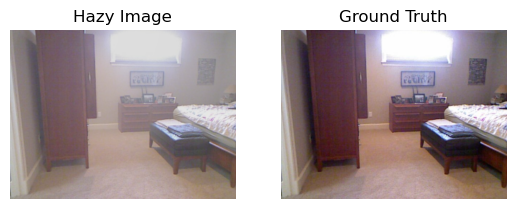

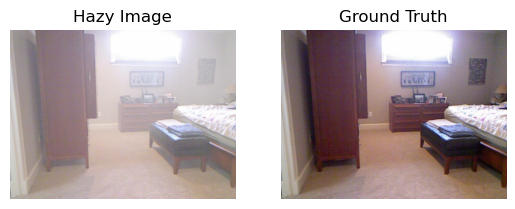

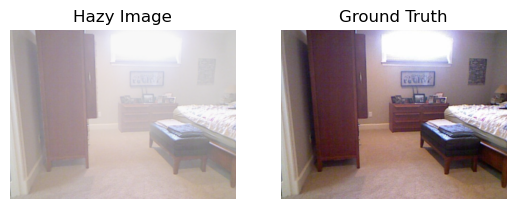

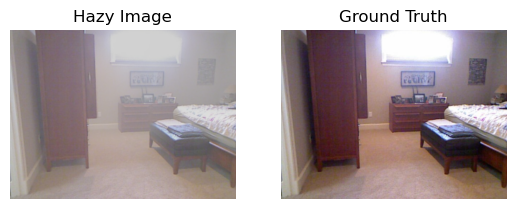

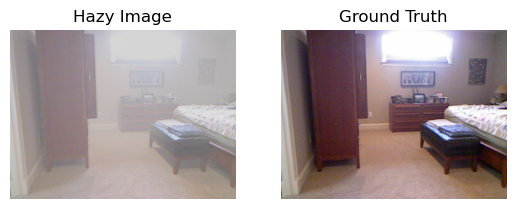

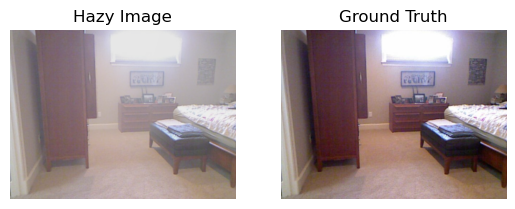

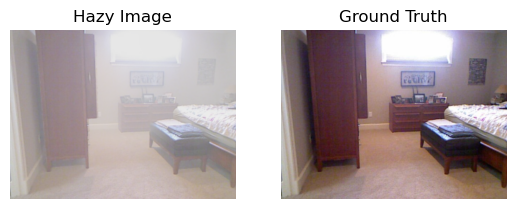

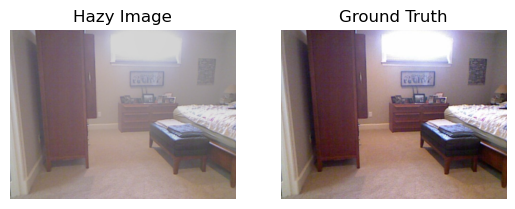

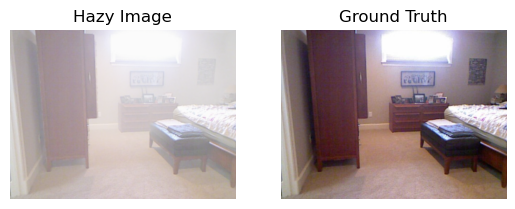

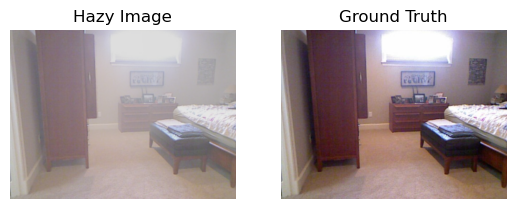

In [78]:
images = 10

for batch_idx in range(images):
    batch_x, batch_y = train_generator[batch_idx]
    
    for i in range(batch_x.shape[0]):
        hazy_img = batch_x[i]
        gt_img = batch_y[i]
        
        plt.subplot(1, 2, 1)
        plt.imshow(hazy_img)
        plt.title('Hazy Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(gt_img)
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.show()

In [11]:
# def Model_(input_shape=(360, 480, 3)):
#     input_img = Input(shape=input_shape)
    
#     x1 = Conv2D(64, (3, 3), padding='same')(input_img)
#     x1 = BatchNormalization()(x1)
#     x1 = LeakyReLU(alpha=0.1)(x1)
#     x1_pool = MaxPooling2D((2, 2), padding='same')(x1)
    
#     x2 = Conv2D(128, (3, 3), padding='same')(x1_pool)
#     x2 = BatchNormalization()(x2)
#     x2 = LeakyReLU(alpha=0.1)(x2)
#     x2_pool = MaxPooling2D((2, 2), padding='same')(x2)
    
#     x3 = Conv2D(256, (3, 3), padding='same')(x2_pool)
#     x3 = BatchNormalization()(x3)
#     x3 = LeakyReLU(alpha=0.1)(x3)
#     encoded = MaxPooling2D((2, 2), padding='same')(x3)
    
#     x = Conv2D(256, (3, 3), padding='same')(encoded)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
    
#     x = Concatenate()([x, x3])
    
#     x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
    
#     x = Concatenate()([x, x2])
    
#     x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
    
#     x = Concatenate()([x, x1])
    
#     decoded = Conv2D(3, (3, 3), padding='same')(x) 
#     autoencoder = Model(input_img, decoded)
    
#     return autoencoder

# def Model_(input_shape=(360, 480, 3)):
#     input_img = Input(shape=input_shape)
    
#     x1 = Conv2D(32, (3, 3), padding='same')(input_img)
#     x1 = BatchNormalization()(x1)
#     x1 = LeakyReLU(alpha=0.1)(x1)
#     x1_pool = MaxPooling2D((2, 2), padding='same')(x1)
    
#     x2 = Conv2D(64, (3, 3), padding='same')(x1_pool)
#     x2 = BatchNormalization()(x2)
#     x2 = LeakyReLU(alpha=0.1)(x2)
#     x2_pool = MaxPooling2D((2, 2), padding='same')(x2)
    
#     x3 = Conv2D(128, (3, 3), padding='same')(x2_pool)
#     x3 = BatchNormalization()(x3)
#     x3 = LeakyReLU(alpha=0.1)(x3)
#     encoded = MaxPooling2D((2, 2), padding='same')(x3)
    
#     x = Conv2D(128, (3, 3), padding='same')(encoded)
#     x = LeakyReLU(alpha=0.1)(x)
    
#     x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = Concatenate()([x, x3])
    
#     x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = Concatenate()([x, x2])
    
#     x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU(alpha=0.1)(x)
#     x = Concatenate()([x, x1])
    
#     decoded = Conv2D(3, (3, 3), padding='same')(x) 
#     autoencoder = Model(input_img, decoded)
    
#     return autoencoder

def ssim_loss(y_true, y_pred):
    y_true = tf.image.convert_image_dtype(y_true, tf.float32)
    return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

In [12]:
dehaze_model = Model_()
checkpoint_filepath = 'model_checkpoints/dehaze_checkpoint.h5'
dehaze_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 360, 480, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 360, 480, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 360, 480, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 360, 480, 32)         0         ['batch_normalization[0][0

Total params: 434483 (1.66 MB)
Trainable params: 434035 (1.66 MB)
Non-trainable params: 448 (1.75 KB)
__________________________________________________________________________________________________


In [94]:
# dehaze_model = Model_()
# dehaze_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                                 loss=[ssim_loss, 'mse'], loss_weights=[0.75, 0.25])

# checkpoint_filepath = 'model_checkpoints/dehaze_checkpoint.h5'
# dehaze_model.load_weights(checkpoint_filepath)

In [ ]:
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True
# )

In [ ]:
# history = dehaze_model.fit(
#     train_generator,
#     initial_epoch=0,
#     epochs=10,
#     validation_data=validation_generator,
#     callbacks=[model_checkpoint_callback]
# )

In [ ]:
# with open('training_history_2.pkl', 'wb') as file:
#     pickle.dump(history.history, file)

# dehaze_model.save('saved_models/dehaze_model.h5') 

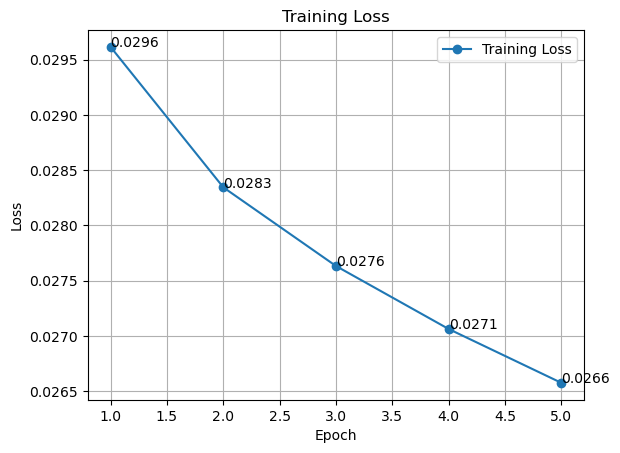

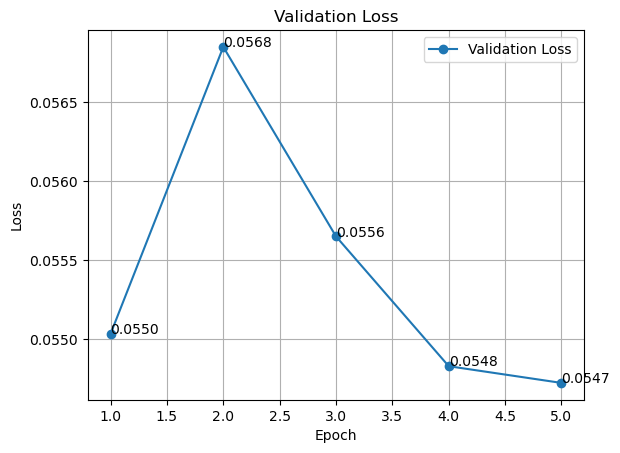

In [13]:
with open('model_2/training_history_2.pkl', 'rb') as file:
    history = pickle.load(file)
    
training_loss = history['loss']
validation_loss = history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
for i, loss in enumerate(training_loss):
    plt.annotate(f'{loss:.4f}', (epochs[i], loss))

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='-')
for i, loss in enumerate(validation_loss):
    plt.annotate(f'{loss:.4f}', (epochs[i], loss))

plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
original_model = tf.keras.models.load_model('./model_2/saved_models_2/dehaze_model.h5', custom_objects={'ssim_loss': ssim_loss})

# Convert the model to a quantized version
converter = tf.lite.TFLiteConverter.from_keras_model(original_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

# Save the quantized model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_model)

INFO:tensorflow:Assets written to: C:\Users\aasha\AppData\Local\Temp\tmpc433yjx2\assets


INFO:tensorflow:Assets written to: C:\Users\aasha\AppData\Local\Temp\tmpc433yjx2\assets


In [44]:
tf.keras.backend.clear_session()

tf.config.optimizer.set_jit(True)

# img = cv2.imread('./img.jpg')
img = cv2.imread('./reside indoor/train/hazy/46_10_0.84396.png')
img_ = cv2.imread('./reside indoor/train/GT/46_10_0.84396.png')

In [45]:
async def dehaze_frame(frame, location):
    def ssim_loss(y_true, y_pred):
        y_true = tf.image.convert_image_dtype(y_true, tf.float32)
        return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
    
    dehaze_model = tf.keras.models.load_model(location, custom_objects={'ssim_loss': ssim_loss})
    
    processed_frame = cv2.resize(frame, (480, 360), interpolation=cv2.INTER_LINEAR)
    processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
    
    processed_frame_1 = np.expand_dims(processed_frame, axis=0)
    dehazed_frame = dehaze_model.predict(processed_frame_1)
    dehazed_frame = np.squeeze(dehazed_frame, axis=0)  
    
    return processed_frame, dehazed_frame

1/1 [==============================] - 0s 311ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


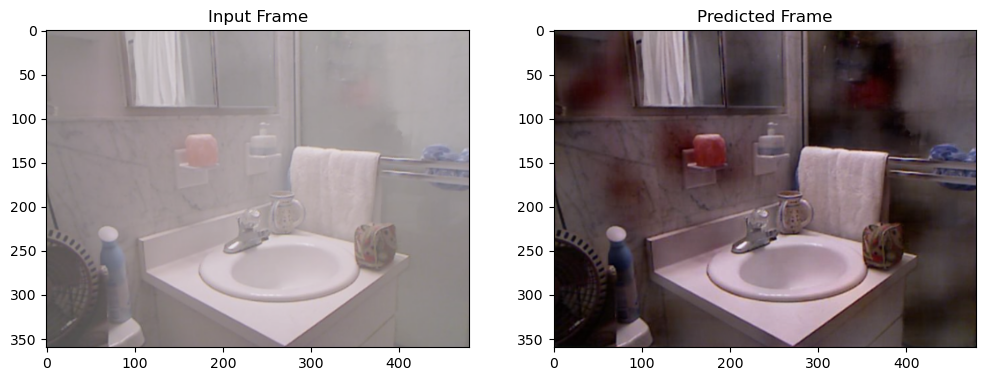

1/1 [==============================] - 0s 333ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


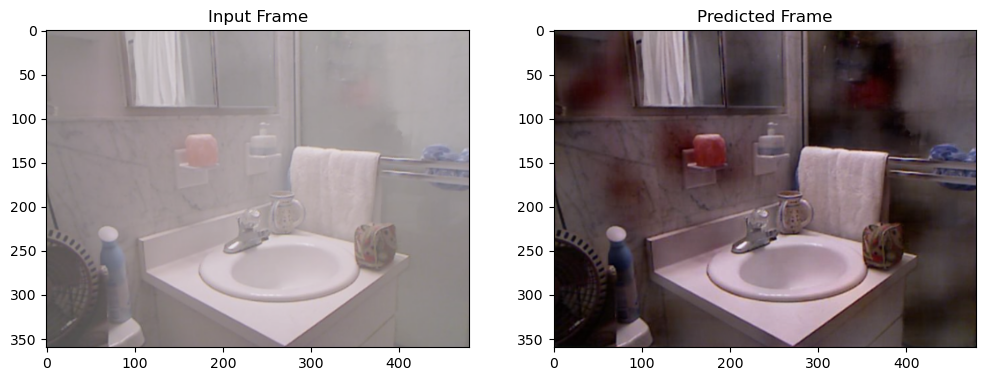

1/1 [==============================] - 0s 312ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


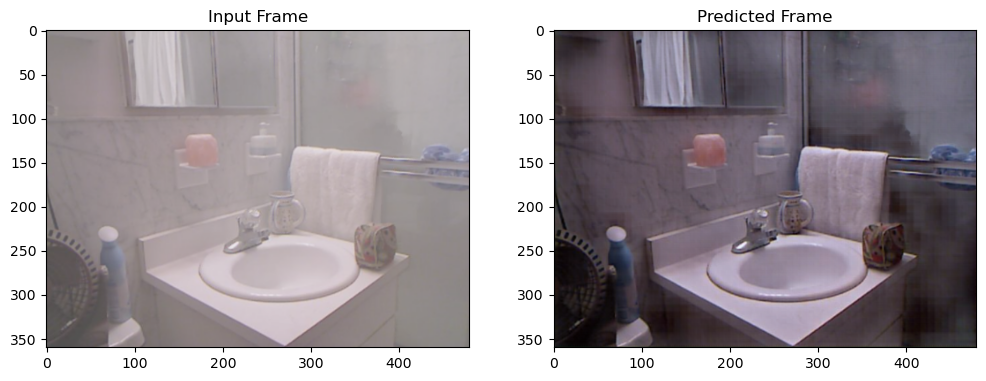

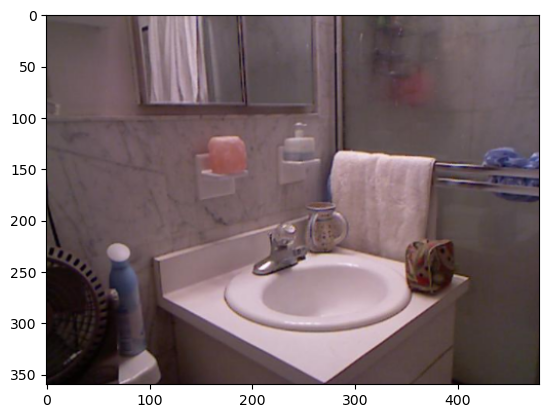

In [46]:
# input_, output_ = await dehaze_frame(img, './model_2/saved_models/dehaze_model.h5')
input_, output_ = await dehaze_frame(img, './saved_models/dehaze_model.h5')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(input_)
axes[0].set_title('Input Frame')

axes[1].imshow(output_)
axes[1].set_title('Predicted Frame')
plt.show()

input_, output_ = await dehaze_frame(img, './model_3/saved_models/dehaze_model.h5')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(input_)
axes[0].set_title('Input Frame')

axes[1].imshow(output_)
axes[1].set_title('Predicted Frame')
plt.show()

input_, output_ = await dehaze_frame(img, './model_1/saved_models/dehaze_model.h5')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(input_)
axes[0].set_title('Input Frame')

axes[1].imshow(output_)
axes[1].set_title('Predicted Frame')

plt.show()

img_ = cv2.resize(img_, (480, 360), interpolation=cv2.INTER_LINEAR)
img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
plt.imshow(img_)
plt.show()

In [36]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import Sequence
# import cv2
# import numpy as np
# import os
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model
# import pickle
# import asyncio
# import matplotlib.pyplot as plt

# async def dehaze_frame(frame):
#     def ssim_loss(y_true, y_pred):
#         y_true = tf.image.convert_image_dtype(y_true, tf.float32)
#         return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)

#     dehaze_model = tf.keras.models.load_model('./saved_models/dehaze_model.h5', custom_objects={'ssim_loss': ssim_loss})
    
#     processed_frame = cv2.resize(frame, (480, 360), interpolation=cv2.INTER_LINEAR)
#     processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
#     processed_frame = np.expand_dims(processed_frame, axis=0)
    
#     dehazed_frame = dehaze_model.predict(processed_frame)
    
#     dehazed_frame = np.squeeze(dehazed_frame, axis=0)  
    
#     return dehazed_frame


# async def process_frames(frames):
#     tasks = []
    
#     for frame in frames:
#         task = asyncio.create_task(dehaze_frame(frame))
#         tasks.append(task)
    
#     processed_frames = await asyncio.gather(*tasks)
#     return processed_frames

# async def dehaze_video(video_path):
#     video_capture = cv2.VideoCapture(video_path)
    
#     frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
#     frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
#     fps = video_capture.get(cv2.CAP_PROP_FPS)
    
#     frames = []
    
#     success, frame = video_capture.read()
#     while success:
#         frames.append(frame)
#         success, frame = video_capture.read()
    
#     video_capture.release()
    
#     processed_frames = await process_frames(frames)
#     scaled_frames = []
#     for frame in proc_frame:
#         scaled_frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255
#         scaled_frames.append(scaled_frame.astype(np.uint8))

#     output_video_path = './to_dehaze/dehazed.mp4'
#     video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (480, 360))

#     for frame in scaled_frames:
#         video_writer.write(frame)

#     video_writer.release()
#     print(f"Dehazed video saved: {output_video_path}")

In [ ]:
# await dehaze_video('./to_dehaze/video.mp4')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import pickle
import asyncio
import matplotlib.pyplot as plt
import multiprocessing as mp

def dehaze_frame(frame):
    def ssim_loss(y_true, y_pred):
        y_true = tf.image.convert_image_dtype(y_true, tf.float32)
        return 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
    try:
        dehaze_model = tf.keras.models.load_model('./saved_models/dehaze_model.h5', custom_objects={'ssim_loss': ssim_loss})

        processed_frame = cv2.resize(frame, (480, 360), interpolation=cv2.INTER_LINEAR)
        processed_frame = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
        processed_frame = np.expand_dims(processed_frame, axis=0)

        dehazed_frame = dehaze_model.predict(processed_frame)

        dehazed_frame = np.squeeze(dehazed_frame, axis=0)  
        rescaled_output = (dehazed_frame - np.min(dehazed_frame)) / (np.max(dehazed_frame) - np.min(dehazed_frame)) * 255

        return rescaled_output
    except Exception as e:
        print(f"Error dehazing frame: {e}")
        return None

def process_frames(frames):
    try:
        pool = mp.Pool(mp.cpu_count())  # Use the number of available CPU cores
        print(1)
        # Use map to parallelize the frame processing across multiple processes
        processed_frames = pool.map(dehaze_frame, frames)
        pool.close()
        pool.join()
    except Exception as e:
        print(f"Error processing frame: {e}")
        return None
    
    return processed_frames

def dehaze_video(video_path):
    video_capture = cv2.VideoCapture(video_path)
    
    frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    
    frames = []
    
    success, frame = video_capture.read()
    while success:
        frames.append(frame)
        success, frame = video_capture.read()
    
    video_capture.release()
    
    chunked_frames = [frames[i:i + 10] for i in range(0, len(frames), 10)]  # Change chunk size as needed
    
    processed_frames = []
    for chunk in chunked_frames:
        processed_frames.extend(process_frames(chunk))
    
    scaled_frames = []
    for frame in processed_frames:
        scaled_frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame)) * 255
        scaled_frames.append(scaled_frame.astype(np.uint8))
    
    output_video_path = './to_dehaze/dehazed.mp4'
    video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (480, 360))

    for frame in scaled_frames:
        video_writer.write(frame)

    video_writer.release()
    print(f"Dehazed video saved: {output_video_path}")

dehaze_video('./to_dehaze/video.mp4')

1
